## Imports and parameters

In [1]:
# Import packages #

import itertools
import sys
from pathlib import Path
import pandas as pd
import scipy
from graph_tool.all import *
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import os
from os import listdir
import re
import scipy.stats as stats
from IPython.display import display
from PIL import Image
import gc

# Import custom scripts
common_path = Path("/workspace/scripts/common")  # path to common scripts --- change this if needed
sys.path.append(str(common_path))
import networkfuncs # contains custom functions for network analysis

In [13]:
# Set basic parameters --- change for customised use #

datapath = '/workspace/shared/ABIDE/ABIDE2/surface_area/hclust/'  # path to where (most) data is saved
outpath = '/workspace/outputs/ABIDE/ABIDE2/surface_area/python/' # path to where to save (some) analysis outputs
exp_name = 'Autism'  # recognisable name of experimental group
sample_n = 102  # number of observations per group
data_cols = slice(5, None)  # which columns of imported data files contain brain data

# Hierarchical clustering



### Network metrics

To see if the matched control subsample still differs from the synaesthete sample in terms of network properties, we will again compare basic network metrics. However, since we now only have one sample per group, we can only derive one set of metrics per group, which complicates statistical analysis. 

We will use the permutation test for estimating statistical significance, which works by permuting group labels in the cluster-summarised data to generate a null distribution of network metric differences. Furthermore, we will use jackknife resampling to estimate metric variance, which works by recalculating metrics for graphs where one participant has been removed.

In [3]:
# Load matched sample data and generate graphs #

control_filename = 'SA_abs_hc_cntrl_matched.csv'  # filename for matched control sample --- change if needed
exp_filename = 'SA_abs_hc_autism.csv'  # filename for experimental sample --- change if needed

graph_control = networkfuncs.data_to_graphs(datapath+control_filename, data_cols = data_cols)  # generate control graph
graph_exp = networkfuncs.data_to_graphs(datapath+exp_filename, data_cols = data_cols)  # generate experimental graph
graphs = [graph_control] + [graph_exp]  # combine into list for iteration

In [4]:
# Get basic network metrics #

net_metrics = [] # initialise metric list
for graph, group_name in zip(graphs, ['Control'] + [exp_name]):  # for each graph and group
    net_metric = networkfuncs.measure_net(graph)  # get the network metrics
    net_metric['Group'] = group_name  # get the group name
    net_metrics.append(net_metric)  # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True)  # turn network metrics into one df
net_metrics_filename = 'hc_matched_net_metrics.csv'  # filename for saving metrics
net_metrics.to_csv(datapath+net_metrics_filename, index=False)  # write metrics to .csv for external analysis
print(net_metrics)  # display results

   clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0    0.139263    0.182929  3.045137  0.000982  0.013494  Control
1    0.157889    0.202921  2.737532  0.000959  0.012781   Autism


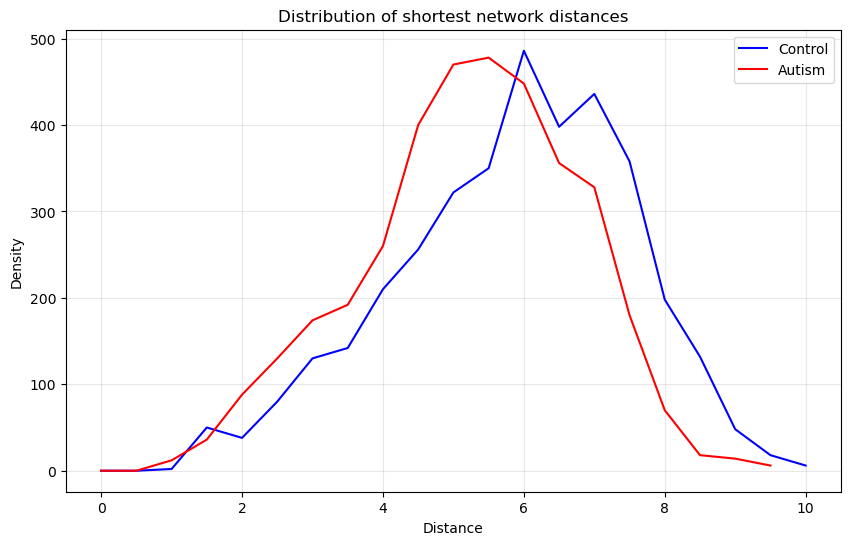

In [5]:
# Plot distribution of network distances #

plt.figure(figsize=(10, 6)) # initialise figure
networkfuncs.plot_network_distances(graph_control, 'Control', 'blue') # plot control distances
networkfuncs.plot_network_distances(graph_exp, exp_name, 'magenta') # plot experimental distances
plt.show() # show plot

In [9]:
# Jackknife resampling to estimate metric variance #

data_control = pd.read_csv(datapath+control_filename)  # read in control data
data_exp = pd.read_csv(datapath+exp_filename)  # read in experimental data
data = [data_control, data_exp]  # put into one list

jackknife_metrics_summary = []  # initialise list for storing summary statistics
jackknife_net_metrics = []  # initialise list for storing all resampled metrics
for i in range(len(data)):  # for each set of data
    group_name = data[i]["Group"].iloc[0]  # get the group name
    n = len(data[i])  # set number of individuals
    jackknife_metrics = []  # initialise list for storing data-specific resampled metrics

    for j in range(n):  # for each individual
        data_jack = data[i].drop(index=data[i].index[j])  # drop one individual
        graph_jack = networkfuncs.data_to_graphs(data_jack, data_cols = data_cols)  # generate graph
        net_metric = networkfuncs.measure_net(graph_jack)  # get network metrics
        jackknife_metrics.append(net_metric.iloc[0])  # put into list

    jackknife_df = pd.DataFrame(jackknife_metrics)  # convert all jackknife metrics to dataframe
    mean_metrics = jackknife_df.mean()  # get mean of metrics
    se_metrics = ((n - 1) / n * ((jackknife_df - mean_metrics) ** 2).sum()) ** 0.5  # calculate SEs using mean of jackknife estimates
    ci_lower = net_metrics.iloc[i,:-1] - 1.96 * se_metrics  # calculate CIs using full-sample metric calculations
    ci_upper = net_metrics.iloc[i,:-1] + 1.96 * se_metrics  # calculate CIs using full-sample metric calculations

    # summarise into dataframe
    summary = pd.DataFrame({
        "Group": group_name,
        "Metric": mean_metrics.index,
        "Mean": mean_metrics.values,
        "SE": se_metrics.values,
        "95% CI Lower": ci_lower.values,
        "95% CI Upper": ci_upper.values
    })

    jackknife_metrics_summary.append(summary)  # add summary stats to list
    jackknife_net_metrics.append(jackknife_df)  # add resampled metrics to list

for metrics, group in zip(jackknife_net_metrics, ['Control'] + [exp_name]):  # for each set of resampled metrics
    metrics['Group'] = [group]*sample_n  # add the group name

jackknife_metrics_summary = pd.concat(jackknife_metrics_summary, ignore_index=True)  # put summary statistics into one df

jackknife_metrics_filename = 'hc_matched_jackknife_metrics.csv'  # filename for saving jackknife resampled metric stats --- change if needed
jackknife_metrics_summary.to_csv(datapath+jackknife_metrics_filename, index=False)  # write jackknife stats to .csv for external analysis
print(jackknife_metrics_summary)  # display results

# print(stats.ttest_ind(jackknife_net_metrics[0].iloc[:,:-1], jackknife_net_metrics[1].iloc[:,:-1])) # can run this to compare metrics, but probably underestimates variance

     Group      Metric      Mean        SE 95% CI Lower 95% CI Upper
0  Control  clustering  0.141255  0.030782      0.07893     0.199595
1  Control  efficiency  0.184906  0.024970     0.133987     0.231871
2  Control       L_obs  3.011773  0.395207     2.270532     3.819742
3  Control     mean_eb  0.000978  0.000068     0.000848     0.001115
4  Control     mean_vb  0.013379  0.002119     0.009342     0.017647
5   Autism  clustering  0.159704  0.033567     0.092098     0.223679
6   Autism  efficiency  0.204601  0.024204     0.155482     0.250361
7   Autism       L_obs  2.714779  0.308840     2.132207     3.342858
8   Autism     mean_eb  0.000951  0.000066      0.00083     0.001087
9   Autism     mean_vb  0.012534  0.002038     0.008787     0.016776


In [21]:
# Permutation tests for network metrics #

# Test group differences in variance - assumption of equal variance
for i in range(len(data_control.iloc[:, data_cols].columns)):  # for the data columns
    p_val = stats.levene(data_control.iloc[:, data_cols].iloc[:, i], data_exp.iloc[:, data_cols].iloc[:, i]).pvalue  # get the Levene test P-value
    if p_val < 0.05:  # if P is less than 0.05
        print(data_control.columns[i], p_val)  # print the cluster number and the P-value

# Set test directionality for one-tailed permutation test (refers to direction of control group)
test_directions = {'clustering': 'less',
                   'efficiency': 'less',
                   'L_obs': 'greater',
                   'mean_eb': 'greater',
                   'mean_vb':'greater'}


np.random.seed(91939) # set seed for consistent permutation
net_metric_perm = networkfuncs.permutation_test_metrics(data_control, data_exp, data_cols = data_cols, # run permutation test
                                                        observed_metrics = net_metrics.iloc[:,:-1], # using previously calculated metrics (excluding group column)
                                                        n_permutations = 10000, # for 10000 permutations
                                                        test_directions = test_directions) # using one-tailed tests with specified directionality


net_metric_perm = pd.concat(net_metric_perm)  # put results into one DataFrame
net_metric_perm['Stat'] = ['P-value', 'Cohen d']  # add column to describe statistics
net_metric_perm_filename = 'hc_matched_net_perm.csv'  # filename for permutation test results
net_metric_perm.to_csv(datapath+net_metric_perm_filename, index=False)  # write permutation test results to .csv for external analysis

Observed differences:
   clustering  efficiency     L_obs   mean_eb   mean_vb
0   -0.018626   -0.019992  0.307605  0.000023  0.000713
Mean null differences:
  clustering efficiency     L_obs mean_eb   mean_vb
0   0.000254   0.000183 -0.002132    -0.0 -0.000011
P-values:
   clustering  efficiency   L_obs  mean_eb  mean_vb
0      0.1116      0.0509  0.0272   0.1272   0.1331
Effect sizes:
   clustering  efficiency     L_obs   mean_eb   mean_vb
0   -1.155571    -1.62398  1.936872  1.128194  1.110576
